### Análise dos resultados do melhor modelo gerado LGBM com Bayes Search

In [1]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Obter dados
df_enem = pd.read_pickle('Bases\MICRODADOS_ENEM_2023_tratados.pkl')

### Resultados da Árvores de decisão

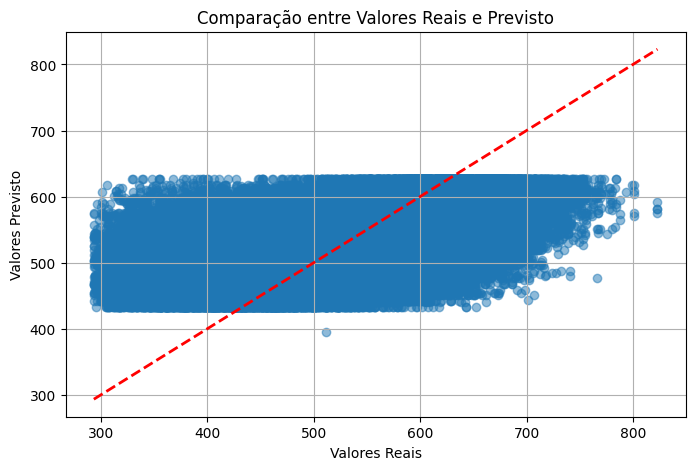

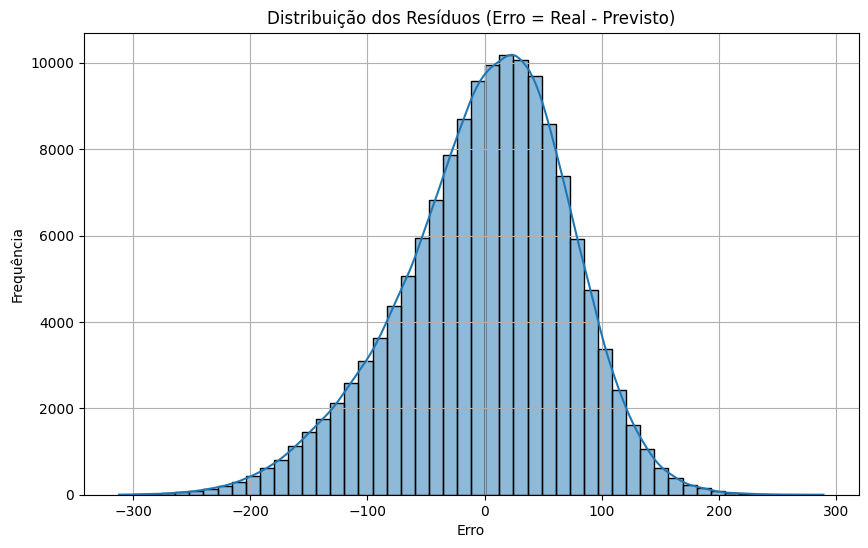

In [5]:
df_enem_arvore = df_enem.copy()

# Aplicar o LabelEncoder para converter as colunas categóricas em numéricas
label_encoder = LabelEncoder()
categorical_columns = df_enem_arvore.select_dtypes(include=['category']).columns

for col in categorical_columns:
    df_enem_arvore[col] = label_encoder.fit_transform(df_enem_arvore[col])

variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']

# separar em treino e teste
X = df_enem_arvore.drop(columns=variaveis_alvo)
y = df_enem_arvore['NUM_NOTA_CH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Carregar modelo treinado
with open('Modelos\modelo_arvore_decisao_best.pkl', 'rb') as file:
    modelo = joblib.load(file)

# Fazer previsões
y_pred = modelo.predict(X_test)

# Criar gráfico de comparação para cada variável alvo
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Comparação entre Valores Reais e Previsto')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previsto')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid()
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribuição dos Resíduos (Erro = Real - Previsto)")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

### Resultados do LGBM

In [6]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']

# separar em treino e teste
X = df_enem.drop(columns=variaveis_alvo)
y = df_enem['NUM_NOTA_CH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143314 entries, 321069 to 80751
Data columns (total 40 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   BIN_Q001_DUMMY_H         143314 non-null  bool    
 1   BIN_Q002_DUMMY_H         143314 non-null  bool    
 2   BIN_Q018                 143314 non-null  bool    
 3   BIN_Q020                 143314 non-null  bool    
 4   BIN_Q021                 143314 non-null  bool    
 5   BIN_Q023                 143314 non-null  bool    
 6   BIN_Q025                 143314 non-null  bool    
 7   CAT_COR_RACA             143314 non-null  category
 8   CAT_CO_MUNICIPIO_ESC     143314 non-null  category
 9   CAT_CO_UF_ESC            143314 non-null  category
 10  CAT_DEPENDENCIA_ADM_ESC  143314 non-null  category
 11  CAT_ENSINO               143314 non-null  category
 12  CAT_ESCOLA               143314 non-null  category
 13  CAT_ESTADO_CIVIL         143314 non-null  cat

In [9]:
# print firsy element of X_train
print(X_test.iloc[0])

BIN_Q001_DUMMY_H             False
BIN_Q002_DUMMY_H             False
BIN_Q018                     False
BIN_Q020                     False
BIN_Q021                     False
BIN_Q023                     False
BIN_Q025                      True
CAT_COR_RACA                     1
CAT_CO_MUNICIPIO_ESC       2308104
CAT_CO_UF_ESC                   23
CAT_DEPENDENCIA_ADM_ESC          2
CAT_ENSINO                       1
CAT_ESCOLA                       2
CAT_ESTADO_CIVIL                 1
CAT_FAIXA_ETARIA                 2
CAT_LINGUA                       0
CAT_LOCALIZACAO_ESC              1
CAT_NACIONALIDADE                1
CAT_Q003                         A
CAT_Q004                         A
CAT_SEXO                         F
CAT_SIT_FUNC_ESC                 1
NUM_Q001                         1
NUM_Q002                         3
NUM_Q005                         5
NUM_Q006                         1
NUM_Q007                         0
NUM_Q008                         2
NUM_Q009            

In [10]:
# Carregar modelo treinado
with open('Modelos\modelo_lgbm_bayes.pkl', 'rb') as file:
    modelo = joblib.load(file)

In [11]:
# Aplicar o modelo nos dados de teste
y_pred = modelo.predict(X_test)

Comparativo entre resultados reais e resultados previstos

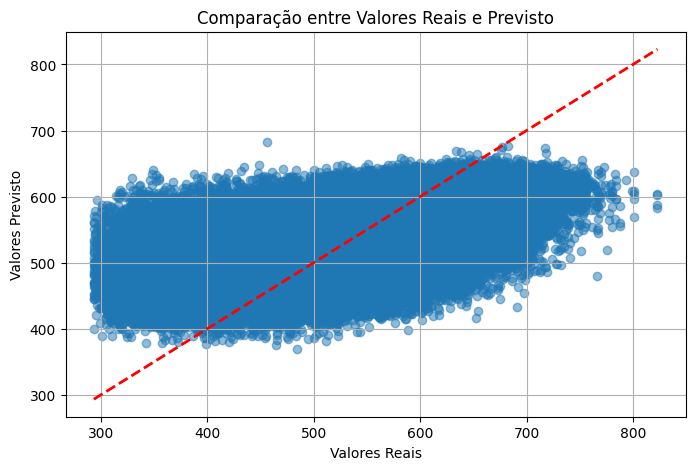

In [12]:
# Criar gráfico de comparação para cada variável alvo
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Comparação entre Valores Reais e Previsto')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previsto')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid()
plt.show()

#### Resultados com primeiro processamento de dados incluindo Outliers em zero

![Execução com primeiro pré-processamento](Resultados/resultado_modelo_incluindo_zeros_lgbm_outliers.png)

- Tendencia geral é reconhecida pelo modelo
- Há uma distribuição atípica quando os valores reais são zero, os quais no modelo são previsto entre 350 e 650 aproximadamente
- O modelo não consegue prever zeros: no caso são outliers já previstos na exploração dos dados
- Faltam exemplos de zero para o modelo melhorar o treinamento e conseguir realizar esta previsão
- O modelo preve bem entre 350 e 650, mas tem dificuldade fora dessa margem: underfitting ou necessidade de melhora dos hiperparâmetros
- Há subestimação das notas alta e superstimação das notas baixas

#### Ideias:

- Trabalhar melhor com o zeros: 
    - estudar o significado deles, são casos reais de fato?
    - remover outliers
    - rever hiperparâmetros

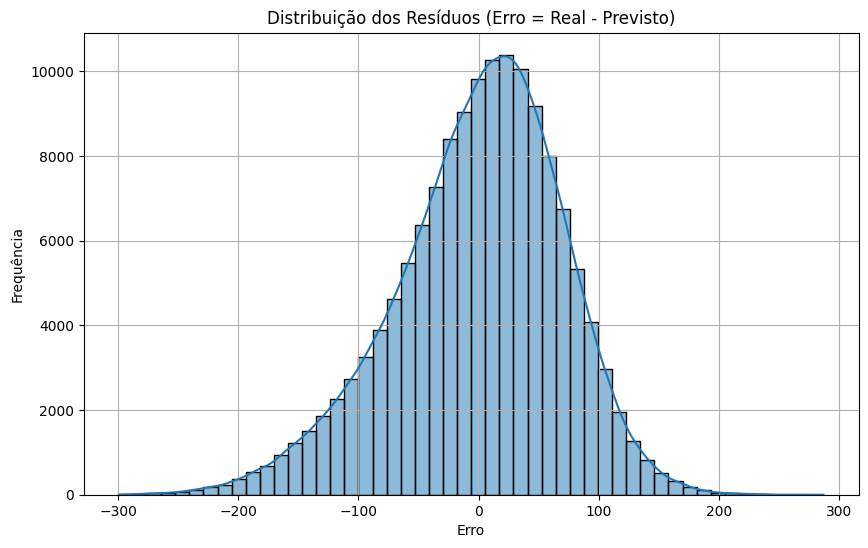

In [13]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribuição dos Resíduos (Erro = Real - Previsto)")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

#### Resultados com primeiro processamento de dados incluindo Outliers em Zero

![Execução com primeiro pré-processamento](Resultados/resultado_modelo_incluindo_zeros_residuos.png)

#### Análise dos resíduos

- distribuição se mostra normal centrada em zero
- os erros estão em geral em torno de zero
- modelo está com baixo viés não superestimando ou subestimando as notas

#### Notas Zero

- Verificar se são reais ou não
    - Se não forem reais (ausencia ou erro) deve-se remover
    - Se forem reais é interessante criar um modelo para prever zeros ou uma coluna de prova realiza ou não

In [14]:
df_resultado = pd.DataFrame({'real': y_test, 'previsto': y_pred})
df_resultado['faixa'] = pd.cut(df_resultado['real'], bins=[0, 300, 500, 700, 1000])

# Corrigir o aviso de depreciação com include_groups=False
resultados = df_resultado.groupby('faixa', observed=False).apply(
    lambda x: mean_absolute_error(x['real'], x['previsto']), include_groups=False
)
print(resultados)

faixa
(0, 300]       201.545286
(300, 500]      69.132923
(500, 700]      46.181468
(700, 1000]    127.771426
dtype: float64


In [15]:
# Criar faixas e calcular porcentagem e MAE em um único DataFrame
df_porcentagem = (
    df_resultado
    .assign(Faixa=pd.cut(df_resultado['real'], bins=[0, 300, 500, 700, 1000]))
    .groupby('Faixa', observed=False)
    .agg(
        Amostra=('real', lambda x: round(len(x) / len(df_resultado) * 100, 1)),
        MAE=('real', lambda x: mean_absolute_error(x, df_resultado.loc[x.index, 'previsto']))
    )
    .reset_index()
)

print(df_porcentagem)

         Faixa  Amostra         MAE
0     (0, 300]      0.1  201.545286
1   (300, 500]     34.5   69.132923
2   (500, 700]     64.4   46.181468
3  (700, 1000]      1.0  127.771426


#### Resultados com primeiro processamento de dados incluindo Outliers

#### MAE por faixa da base pré-processada inicial

    faixa
    (0, 300]       194.537290
    (300, 500]      68.541698
    (500, 700]      46.976290
    (700, 1000]    127.130647

- Maior erro está abaixo de 300
- Depois acima de 700 -> Pode haver uma baixa quantidade de amostrar para valores acima de 700

### Balancear dados

- SMOTE ou subamostragem para equilibrar extremidades
- ponderar erros por faixa
- criar modelos diferentes para faixas diferentes